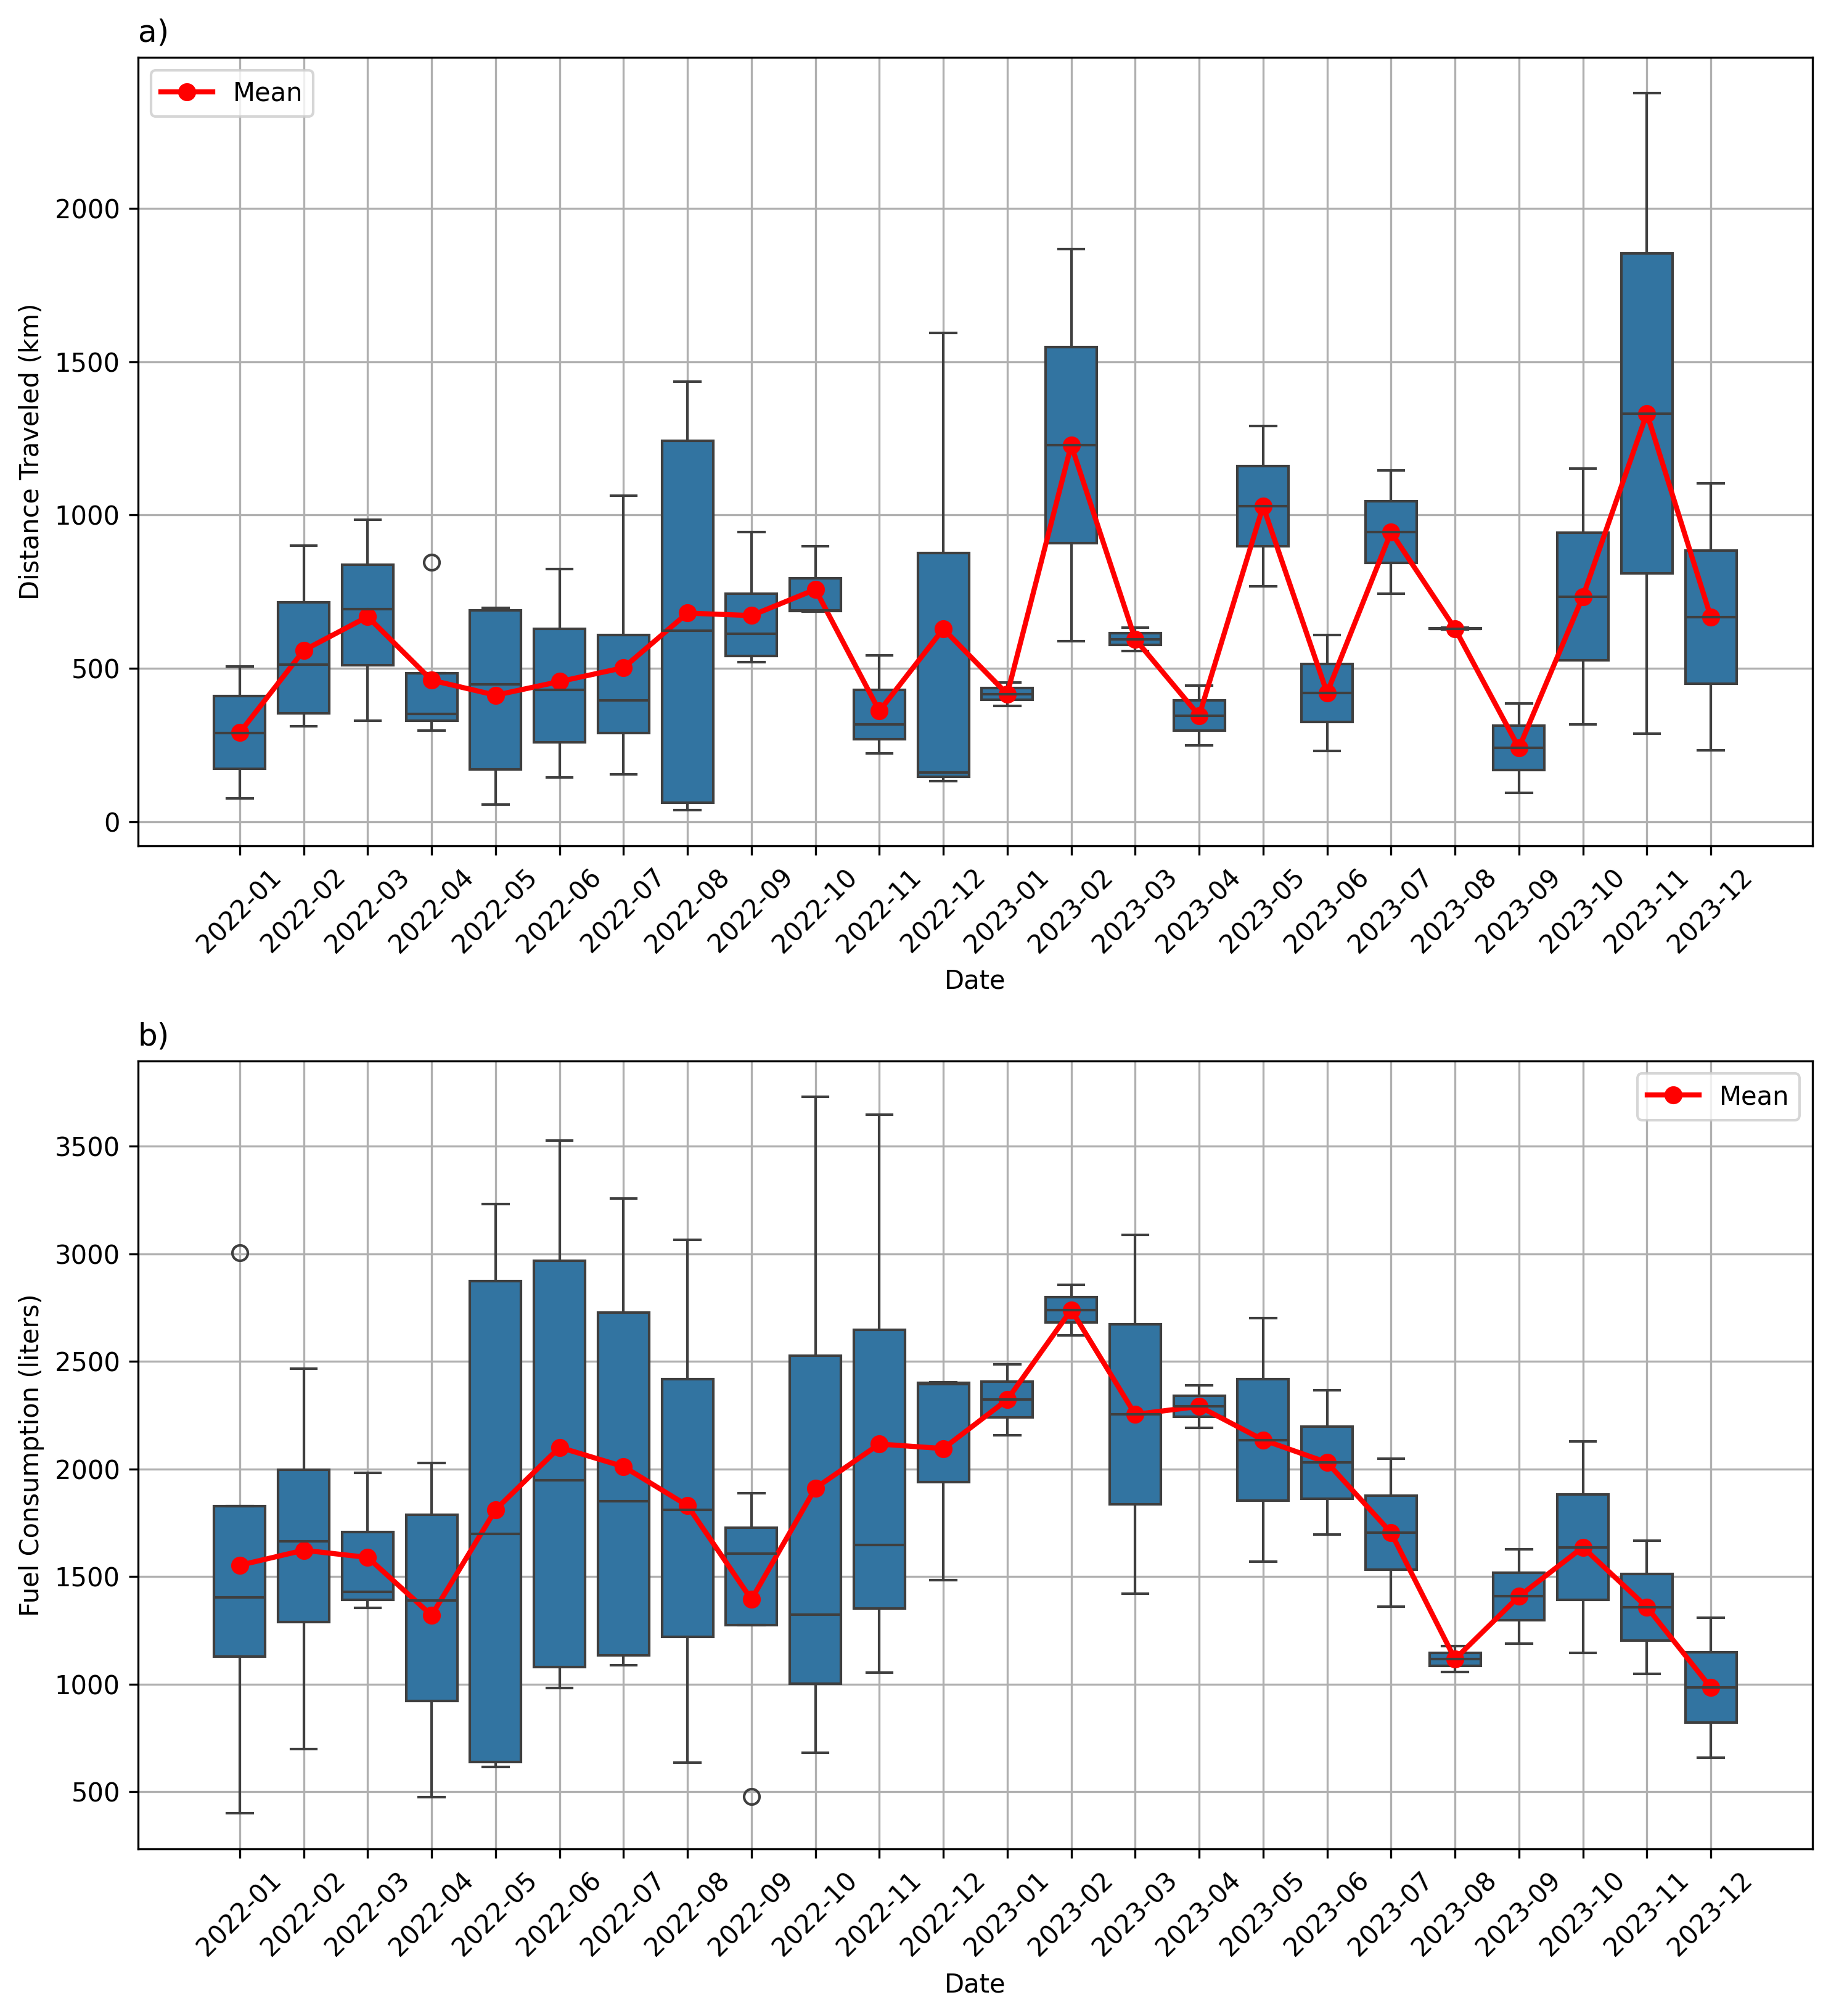

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convert date and time columns to datetime
df['Guardar_Marca'] = pd.to_datetime(df['Guardar_Marca'], errors='coerce')

# Filter points with speed equal to 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Sort the data by vessel and time
df = df.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Create a geometry column from longitude and latitude columns
df['geometry'] = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Calculate the distance between consecutive points in time for each vessel
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Replace NaN in distance and time columns with 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calculate fuel consumption (liters) based on engine power and operation time
# Assuming a consumption of 0.1 gallons per hour per HP, converted to liters
gal_to_liters = 3.78
engine_power_hp = 100
gdf['Consumo_litros'] = gdf['Tiempo_horas'] * engine_power_hp * 0.1 * gal_to_liters

# Identify and remove outliers in fuel consumption
# Here, an outlier is defined as any value above the 99th percentile
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Create a year-month column
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M')

# Calculate the total distance traveled, fuel consumption, and hours at sea monthly for each vessel
monthly_distance_fuel = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calculate the monthly averages of distance traveled, fuel consumption, and time at sea
mean_distance = monthly_distance_fuel.groupby('YearMonth')['Distancia_km'].mean()
mean_fuel = monthly_distance_fuel.groupby('YearMonth')['Consumo_litros'].mean()

# Plot the boxplots in a single figure
fig, axes = plt.subplots(2, 1, figsize=(10, 11), dpi=300)

# Plot a boxplot of the monthly distance traveled for all vessels
sns.boxplot(ax=axes[0], x='YearMonth', y='Distancia_km', data=monthly_distance_fuel)
axes[0].plot(mean_distance.index.astype(str), mean_distance.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[0].set_title('a)', loc='left')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Distance Traveled (km)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend()

# Plot a boxplot of the monthly fuel consumption for all vessels
sns.boxplot(ax=axes[1], x='YearMonth', y='Consumo_litros', data=monthly_distance_fuel)
axes[1].plot(mean_fuel.index.astype(str), mean_fuel.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[1].set_title('b)', loc='left')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Fuel Consumption (liters)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



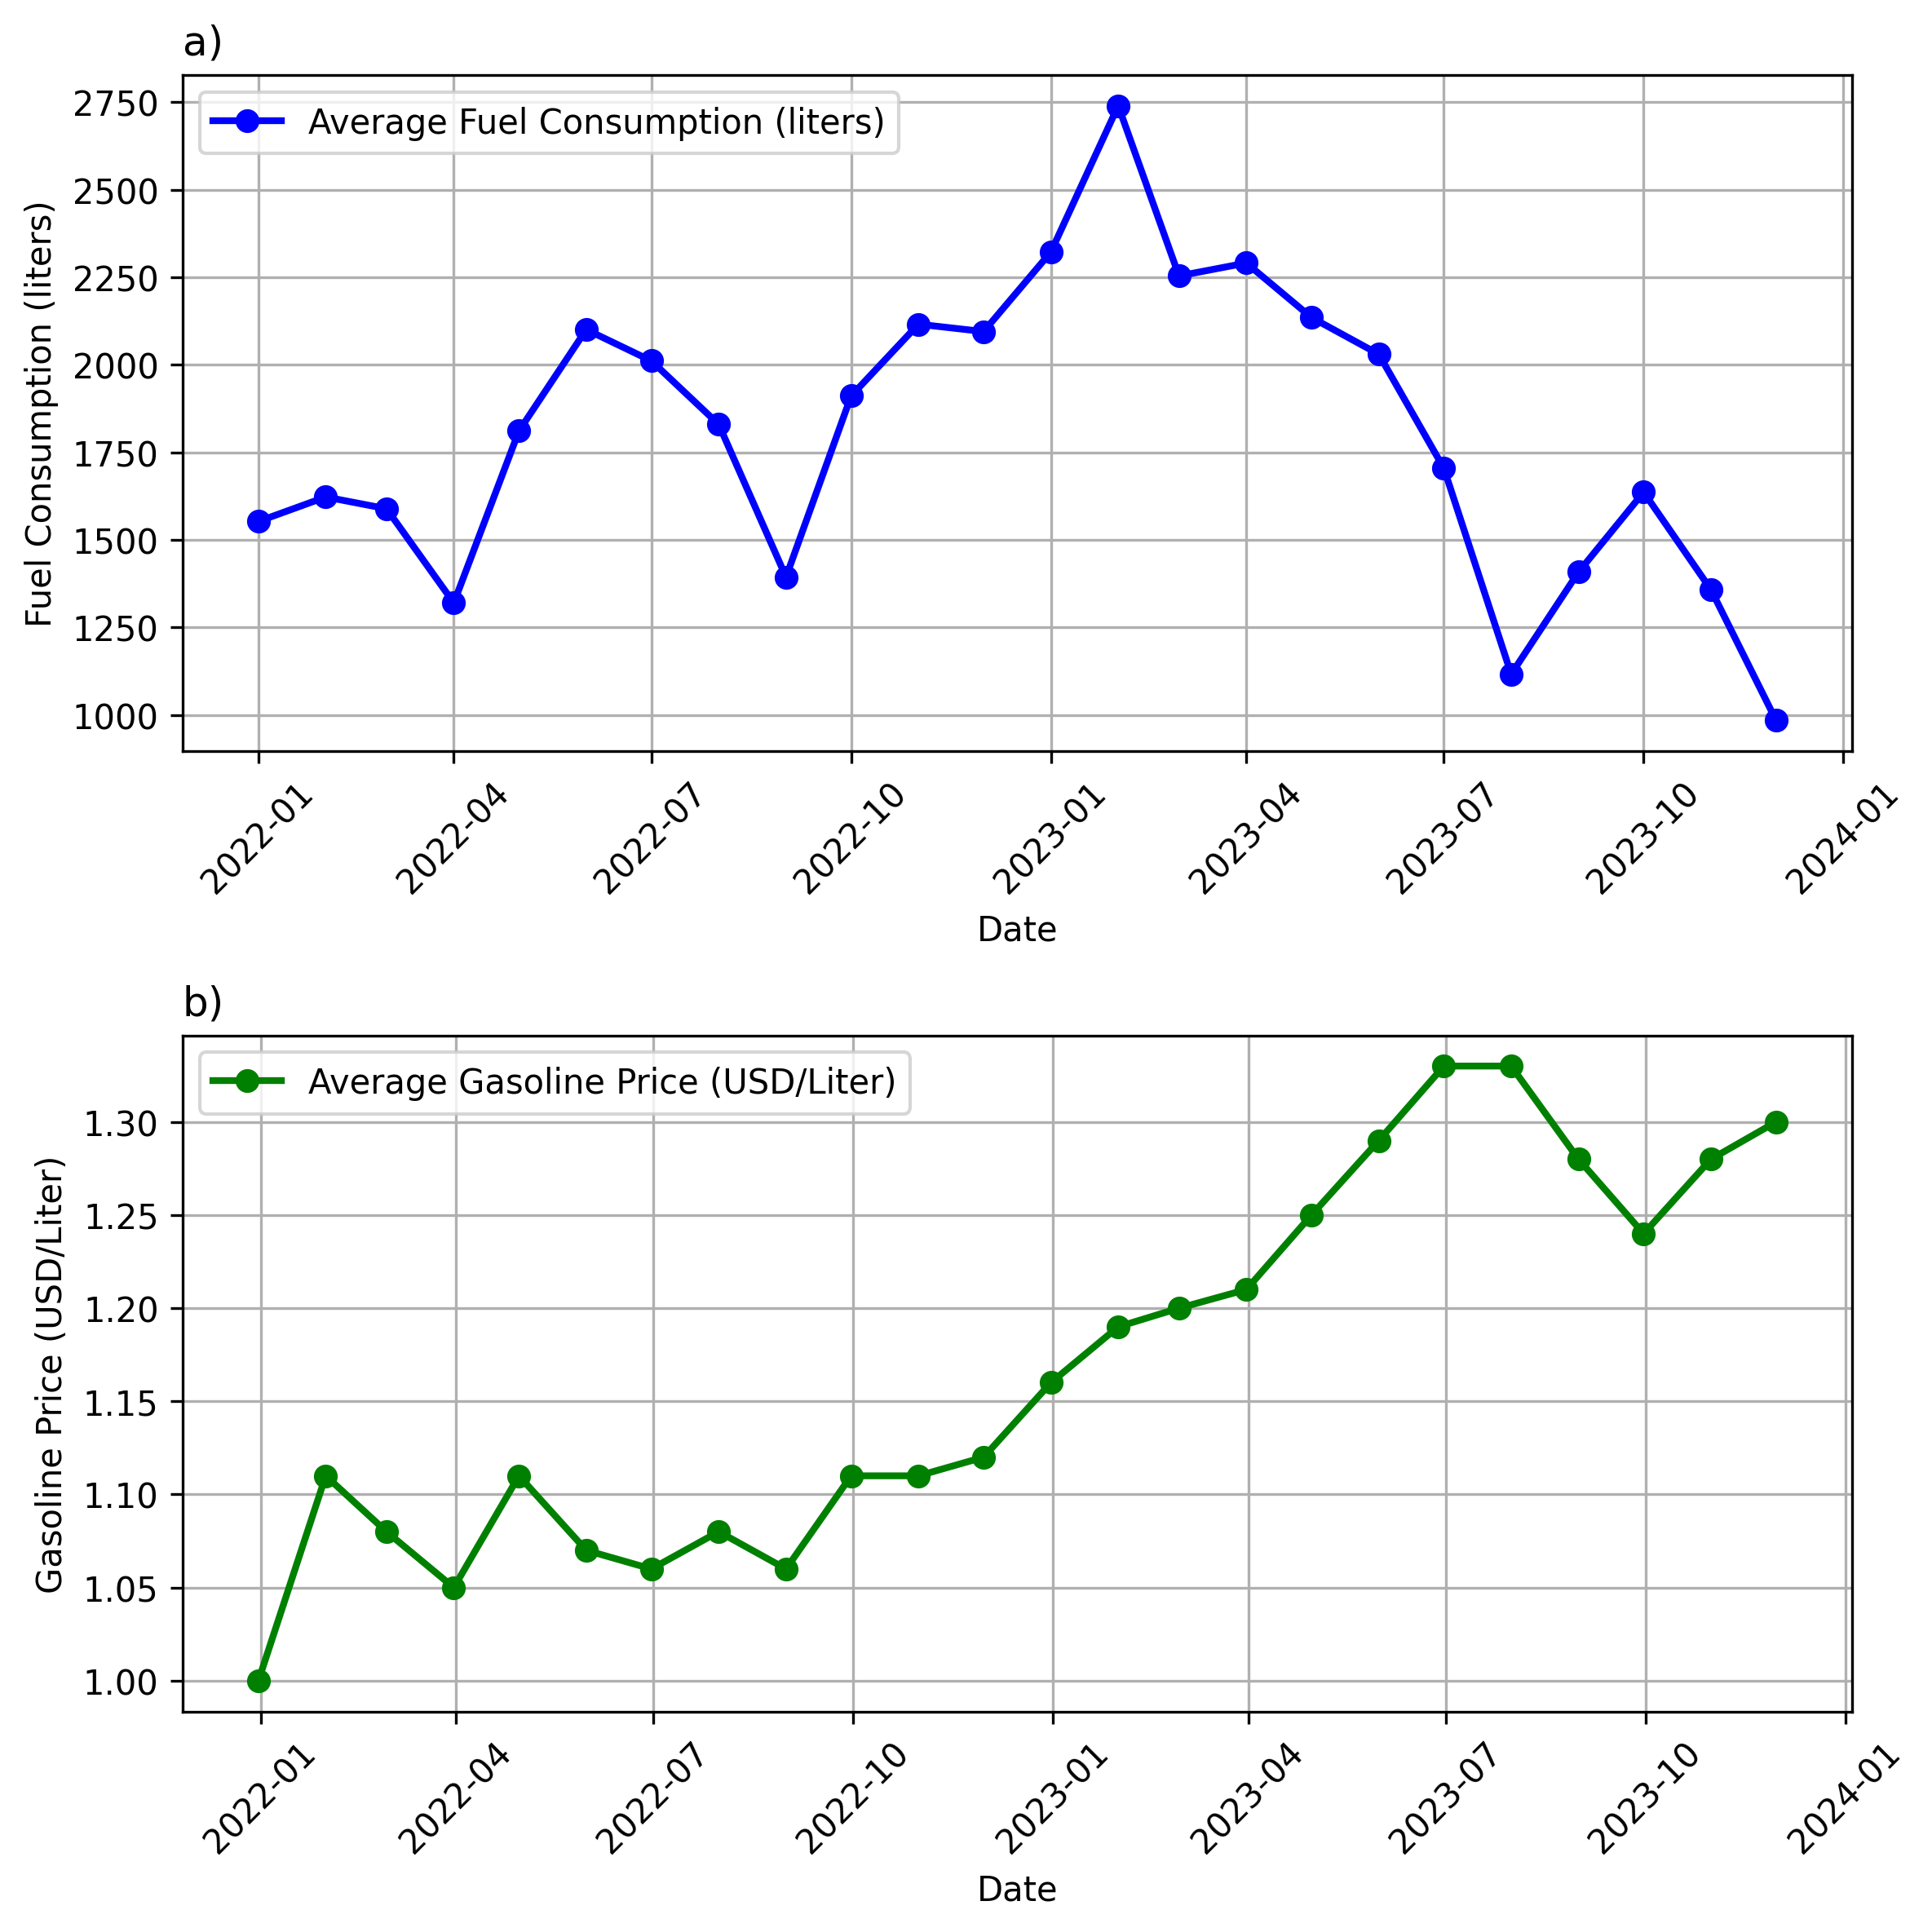

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df_vms = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df_vms['Guardar_Marca'] = pd.to_datetime(df_vms['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df_vms = df_vms[df_vms['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df_vms = df_vms.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df_vms['geometry'] = [Point(xy) for xy in zip(df_vms.Longitud, df_vms.Latitud)]
gdf = gpd.GeoDataFrame(df_vms, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación
# Asumimos un consumo de 0.1 galones por hora por cada HP, convertido a litros
gal_to_liters = 3.78
potencia_hp = 100
gdf['Consumo_litros'] = gdf['Tiempo_horas'] * potencia_hp * 0.1 * gal_to_liters

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M').dt.to_timestamp()

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Datos del precio de la gasolina en México (USD/Litro)
data_gas = {
    'Date': pd.date_range(start='2021-12-01', periods=24, freq='ME'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df_gas = pd.DataFrame(data_gas)

# Asegurar que las fechas coinciden exactamente
medias_consumo = medias_consumo.reset_index()
medias_consumo['YearMonth'] = pd.to_datetime(medias_consumo['YearMonth'])
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=300)

# Graficar el promedio de consumo de gasolina
ax1.plot(medias_consumo['YearMonth'], medias_consumo['Consumo_litros'], color='blue', marker='o', linestyle='-', linewidth=2, label='Average Fuel Consumption (liters)')
ax1.set_title('a)',loc='left')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Consumption (liters)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Graficar el precio promedio de la gasolina
ax2.plot(df_gas['Date'], df_gas['Price (USD/Liter)'], color='green', marker='o', linestyle='-', linewidth=2, label='Average Gasoline Price (USD/Liter)')
ax2.set_title('b)',loc='left')
ax2.set_xlabel('Date')
ax2.set_ylabel('Gasoline Price (USD/Liter)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
